In [5]:
from opentelemetry import trace
from opentelemetry.sdk.trace import TracerProvider
from opentelemetry.sdk.trace.export import SimpleSpanProcessor
from openinference.instrumentation.smolagents import SmolagentsInstrumentor
from opentelemetry.exporter.otlp.proto.http.trace_exporter import OTLPSpanExporter

from dotenv import load_dotenv
from kiwipiepy import Kiwi
import os
from huggingface_hub import login

# Hugging Face 로그인 코드
# def huggingface_login():
#     login(token=os.getenv("HUGGING_FACE_API_KEY"))

# huggingface_login()
load_dotenv()
kiwi = Kiwi()

def kiwi_tokenize(text):
    return [token.form for token in kiwi.tokenize(text)] 


# endpoint = "http://0.0.0.0:6006/v1/traces"
# trace_provider = TracerProvider()
# trace_provider.add_span_processor(SimpleSpanProcessor(OTLPSpanExporter(endpoint)))

# SmolagentsInstrumentor().instrument(tracer_provider=trace_provider)

In [4]:
from langchain_community.document_loaders import PDFPlumberLoader
from langchain.docstore.document import Document
from smolagents import CodeAgent, HfApiModel, ToolCallingAgent, MultiStepAgent, OpenAIServerModel
from src.tools import GetResponse, OpenAPIGuideRetriever
        
def list_pdf_files(directory: str) -> list:
    """
    주어진 디렉토리에서 PDF 파일 목록(전체 경로)을 반환합니다.
    """
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.lower().endswith('.pdf')]

def load_pdf_documents(pdf_files: list) -> list:
    """
    PDF 파일 목록을 받아 각 파일을 Document 객체로 변환합니다.
    PyMuPDFLoader를 사용하여 PDF 파일의 모든 페이지 텍스트를 추출하고,
    이를 하나의 Document 객체로 결합합니다.
    """
    documents = []
    for pdf_path in pdf_files:
        try:
            loader = PDFPlumberLoader(pdf_path)
            docs = loader.load()  # 각 페이지별 Document 객체 리스트
            # 모든 페이지 텍스트를 하나로 결합
            full_text = "\n".join([doc.page_content for doc in docs])
            document = Document(page_content=full_text, metadata={"source": pdf_path})
            documents.append(document)
        except Exception as e:
            print(f"Error loading {pdf_path}: {e}")
    return documents

openapi_dir = 'docs/openapi/'
pdf_files = list_pdf_files(openapi_dir)

print(f"{len(pdf_files)}개의 PDF 파일을 발견하였습니다.")
docs = load_pdf_documents(pdf_files)
print(f"총 {len(docs)}개의 Document 객체를 생성하였습니다.")

model = HfApiModel()
model = OpenAIServerModel(model_id='gpt-4.1-mini')

get_response = GetResponse()
open_api_guide_retriever = OpenAPIGuideRetriever(docs)
tools =[open_api_guide_retriever,get_response]

tool_agent = ToolCallingAgent(
    model=model,
    tools=tools,
    name = "OpenAPI guide document retrieve agent",
    description="""
    You are an agent that reads the API guide document and finds the necessary information to report. The report must include the Call Back URL (not the service URL), request parameter, response parameter, and response message JSON structure.
    """,
    max_steps = 1
)
rag_agent = MultiStepAgent(
    tools = tools,
    model = model,
    name="managed_agent",
    description="""
    You are an agent that reads the API guide document and finds the necessary information to report. The report must include the callback URL, request parameter, response parameter, and response message JSON structure.
    """,
    managed_agents=[tool_agent],
    max_steps=3
)
LH_agent = CodeAgent(
    tools=tools,
    model=model,
    additional_authorized_imports=["json","requests"],
    use_e2b_executor=False,
    max_steps = 6
)

open_api_query = '분양임대공고조회'
LH_opt = {'지역' : "서울",
       '기간' : "2024.12.01 ~ 2025.04.10",
       '청약유형' : "주택 임대",
       '공고상태' : ""
       }

#open_api_parameter = tool_agent.run("분양임대공고조회")
#rag_output = rag_agent.run(f"{open_api_query} 관련 문서를 참고해서 API 호출에 필요한 callback url, request 파라미터, response로 받는 파라미터를 작성해서 보고하는데 포맷은 조회한 문서 이름 : 문서이름, callback url : callback url, resquest parameter : parameters")
final_answer = LH_agent.run(task=f'조건(지역, 기간, 청약 유형)을 고려한 주택 임대 공고를 찾기 위해 get_response tool을 호출하여 공고의 공고 제목, 공고문 상세 주소, 공고문 상세 내용(시작일, 마감일, 상태, 유형, 지역)을 정리해서 json 형태로 답변해줘',additional_args=LH_opt,stream=False)

ModuleNotFoundError: No module named 'langchain_community'

In [5]:
from smolagents import OpenAIServerModel
from src.tools import SH_NoticeScraper
import datetime
from smolagents import CodeAgent, HfApiModel, ToolCallingAgent

model = OpenAIServerModel(model_id='gpt-4o-mini')
sh_notice_scraper = SH_NoticeScraper()
sh_url = "https://housing.seoul.go.kr/site/main/sh/publicLease/list?sc=titl&startDate=&endDate=&sv="
sh_agent = CodeAgent(
    description=
    """
    sh_notice_scraper를 사용해서 웹사이트의 게시판 글 목록을 스크래핑하여, 조건(예: 제목에 '장기미임대' 포함, 기간이 '2024-01-01 ~ 2025-05-05')에 맞게 게시글 정보를 정리해서 반환하는 agent.
    """,
    tools=[sh_notice_scraper],
    model=model,
    use_e2b_executor=False,
    max_steps = 6
)
opt = {}
opt['조건']= {'지역' : "서울",
      '기간' : "2024.12.01 ~ 2025.04.10",
      '청약유형' : "",
      'keyword' : "",
      'sh_url' : "https://housing.seoul.go.kr/site/main/sh/publicLease/list?sc=titl&startDate=&endDate=&sv=",
      '공고상태' : ""
      }
today = datetime.date.today()
task_prompt = f"""
<STEP 1>: sh_notice_parser를 호출하기위해 max_pages(int) 조건기간을 고려하여 3개월당 1페이지로 값을 설정. 
keyword 요청이 없을 경우, tool 호출 결과에서 '공고명'에 '발표', '합격자', '경쟁률', '결과'가 포함된 항목을 필터링합니다. STEP 1 코드를 한 번에 작성. </STEP 1>
<STEP 2>: !important 조건(기간, 청약유형, 공고상태)들을 고려해서 결과를 다시 필터링. '공고게시일'이 기간안에 반드시 포함되어야 함. 만약 공고상태나 청약유형 없으면 고려안해도 됨. STEP 2 코드 한번에 작성.</STEP 2>
"""
sh_final_answer = sh_agent.run(task=task_prompt, additional_args=opt, stream=True)
print(sh_final_answer)

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ <STEP 1>: sh_notice_parser를 호출하기위해 max_pages(int) 조건기간을 고려하여 3개월당 1페이지로 값을 설정.       │
│ keyword 요청이 없을 경우, tool 호출 결과에서 '공고명'에 '발표', '합격자', '경쟁률', '결과'가 포함된 항목을      │
│ 필터링합니다. STEP 1 코드를 한 번에 작성. </STEP 1>                                                             │
│ <STEP 2>: !important 조건(기간, 청약유형, 공고상태)들을 고려해서 결과를 다시 필터링. '공고게시일'이 기간안에    │
│ 반드시 포함되어야 함. 만약 공고상태나 청약유형 없으면 고려안해도 됨. STEP 2 코드 한번에 작성.</STEP 2>          │
│                                                                                                                 │
│ You have been provided with these additional arguments, that you can access using the keys as variables in your │
│ python code:                                                                                                    │
│ {'조건': {'지역': '서울', '기간': '2024.12.01 ~ 2025.04.10', '청약유형': '', 'keyword': '', 'sh_url':           │
│ 'https://housing.seoul.go.kr/site/main/sh/publicLease/list?sc=titl&startDate=&endDate=&sv=', '공고상태': ''}}.  │
│                                                                                                                 │
╰─ OpenAIServerModel - gpt-4o-mini ───────────────────────────────────────────────────────────────────────────────╯

<generator object MultiStepAgent._run at 0x31b5a20c0>


In [119]:
from src.tools import YouthNoticeScraper

model = HfApiModel()
model = OpenAIServerModel(model_id='gpt-4o')
youth_notice_scraper = YouthNoticeScraper()
youth_agent =ToolCallingAgent(
    description=
    """
    youth_notice_scraper를 사용해서 웹사이트의 게시판 글 목록을 스크래핑하고 조건(예: 제목에 '공공임대' 포함, 기간이 '2024-01-01 ~ 2025-05-05', 공고명에 포함되어야 하는 keyword '공공')에 맞게 게시글 정보를 정리해서 반환하는 Tool Calling agent.
    """,
    tools=[youth_notice_scraper],
    model=model,
  #  use_e2b_executor=False,
    max_steps = 3
)
opt = {'지역' : "서울",
      '기간' : "2024.07.01 ~ 2025.04.10",
      '청약유형' : "청년안심주택",
      'keyword' : "공공",
      'sh_url' : "https://housing.seoul.go.kr/site/main/sh/publicLease/list?sc=titl&startDate=&endDate=&sv="
      }

task_prompt = f"""
청년안심주택 모집 공고를 youth_notice_scraper을 찾고 조건(지역, 기간)에 맞는 게시글들을 찾아서 결과를 정리해.
참고 사항 1: max_pages 수는 조건 기간이 5개월 당 페이지 4개를 고려해서 tool 호출.
참고 사항 2: 최종 결과는 JSON 형태로 출력
"""
youth_final_answer = youth_agent.run(task=task_prompt, additional_args={'조건':{'지역':opt['지역'],'기간':opt['기간'],'keyword':opt['keyword']}}, stream=False)
print(youth_final_answer)

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 청년안심주택 모집 공고를 youth_notice_scraper을 찾고 조건(지역, 기간)에 맞는 게시글들을 찾아서 결과를 정리해.   │
│ 참고 사항 1: max_pages 수는 조건 기간이 5개월 당 페이지 4개를 고려해서 tool 호출.                               │
│ 참고 사항 2: 최종 결과는 JSON 형태로 출력                                                                       │
│                                                                                                                 │
│ You have been provided with these additional arguments, that you can access using the keys as variables in your │
│ python code:                                                                                                    │
│ {'조건': {'지역': '서울', '기간': '2024.07.01 ~ 2025.04.10', 'keyword': '공공'}}.                               │
│                                                                                                                 │
╰─ OpenAIServerModel - gpt-4o ────────────────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling tool: 'youth_notice_scraper' with arguments: {'max_pages': 8}                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Observations: |{'공고명': '|민간임대] 강변역 비바힐스강변 추가모집공고', '공고게시일': '2025-04-04', '모집마감일': 
'2025-04-08', '청약유형': '민간임대 청년안심주택', '시행사': '정지량 외 6명', '게시글 ID': 6210, '상세 URL': 
'https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6210&menuNo=400008'}, {'공고명': '|민간임대] 구산역 
구산주택 추가모집공고', '공고게시일': '2025-04-04', '모집마감일': '2025-04-08', '청약유형': '민간임대 
청년안심주택', '시행사': '(주)덕영', '게시글 ID': 6211, '상세 URL': 
'https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6211&menuNo=400008'}, {'공고명': '|민간임대] 장한평역
장안동 하트리움 추가모집공고', '공고게시일': '2025-04-03', '모집마감일': '2025-04-06', '청약유형': '민간임대 
청년안심주택', '시행사': '주식회사 씨드원', '게시글 ID': 6209, '상세 URL': 
'https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6209&menuNo=400008'}, {'공고명': '|민간임대] 서울역 
어반허브 서울스테이션 최초모집공고', '공고게시일': '2025-04-01', '모집마감일': '2025-04-11', '청약유형': '민간임대 
청년안심주택', '시행사': '(주)에버그린플라자', '게시글 ID': 6208, '상세 URL': 
'https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6208&menuNo=400008'}, {'공고명': '|민간임대] 동묘앞역
동대문 영하우스 추가모집공고', '공고게시일': '2025-03-31', '모집마감일': '2025-04-03', '청약유형': '민간임대 
청년안심주택', '시행사': '(주)포시즈', '게시글 ID': 6207, '상세 URL': 
'https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6207&menuNo=400008'}, {'공고명': '|민간임대] 노량진역
더써밋타워 추가모집공고', '공고게시일': '2025-03-28', '모집마감일': '2025-04-02', '청약유형': '민간임대 
청년안심주택', '시행사': '코레이트노량진역청년주택 유한회사', '게시글 ID': 6205, '상세 URL': 
'https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6205&menuNo=400008'}, {'공고명': '|민간임대] 개봉역 
세이지움 최초모집공고', '공고게시일': '2025-03-26', '모집마감일': '2025-04-02', '청약유형': '민간임대 
청년안심주택', '시행사': '개봉아이알디피에프브이(주)', '게시글 ID': 6203, '상세 URL': 
'https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6203&menuNo=400008'}, {'공고명': '|민간임대] 
영등포구청역 포레나 당산 추가모집공고', '공고게시일': '2025-03-24', '모집마감일': '2025-03-27', '청약유형': 
'민간임대 청년안심주택', '시행사': '(주)당산동청년주택피에프브이', '게시글 ID': 6200, '상세 URL': 
'https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6200&menuNo=400008'}, {'공고명': '|민간임대] 
서울대입구역 BX201 추가모집공고', '공고게시일': '2025-03-24', '모집마감일': '2025-03-28', '청약유형': '민간임대 
청년안심주택', '시행사': '라온스테이 2030 역세권청년주택 (박정호 외 3인)', '게시글 ID': 6201, '상세 URL': 
'https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6201&menuNo=400008'}, {'공고명': '|민간임대] 노량진역
더클래식 동작 추가모집공고', '공고게시일': '2025-03-19', '모집마감일': '2025-03-24', '청약유형': '민간임대 
청년안심주택', '시행사': '더클래식 동작', '게시글 ID': 6198, '상세 URL': 
'https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6198&menuNo=400008'}, {'공고명': '|민간임대] 노량진역
더써밋타워 추가모집공고', '공고게시일': '2025-03-19', '모집마감일': '2025-03-24', '청약유형': '민간임대 
청년안심주택', '시행사': '코레이트노량진역청년주택 유한회사', '게시글 ID': 6199, '상세 URL': 
'https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6199&menuNo=400008'}, {'공고명': '|민간임대] 길동역 
길동생활(B동) 추가모집공고', '공고게시일': '2025-03-13', '모집마감일': '2025-03-17', '청약유형': '민간임대 
청년안심주택', '시행사': '(주)대한제37호위탁관리부동산투자회사', '게시글 ID': 6196, '상세 URL': 
'https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6196&menuNo=400008'}, {'공고명': '|민간임대] 길동역 
길동생활(A동) 추가모집공고', '공고게시일': '2025-03-13', '모집마감일': '2025-03-17', '청약유형': '민간임대 
청년안심주택', '시행사': '(주)대한제37호위탁관리부동산투자회사', '게시글 ID': 6195, '상세 URL': 
'https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6195&menuNo=400008'}, {'공고명': '|민간임대] 노량진역
더클래식 동작 추가모집공고', '공고게시일': '2025-03-07', '모집마감일': '2025-03-10', '청약유형': '민간임대 
청년안심주택', '시행사': '더클래식 동작', '게시글 ID': 6192, '상세 URL': 
'https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6192&menuNo=400008'}, {'공고명': '|민간임대] 등촌역 
아르체움 등촌 최초모집공고', '공고게시일': '2025-03-07', '모집마감일': '2025-03-17', '청약유형': '민간임대 
청년안심주택', '시행사': '윤호표 외 8인 (대현빌딩)', '게시글 ID': 6193, '상세 URL': 
'https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6193&menuNo=400008'}, {'공고명': '|민간임대] 
건대입구역 더포디엄830 추가모집공고', '공고게시일': '2025-03-06', '모집마감일': '2025-03-10', '청약유형': '민간임대
청년안심주택', '시행사': '(주)엘앤케이이스테이트', '게시글 ID': 6191, '상세 URL': 
'https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6191&menuNo=400008'}, {'공고명': '|민간임대] 
영등포구청역 포레나 당산 추가모집공고', '공고게시일': '2025-03-05', '모집마감일': '2025-03-08', '청약유형': 


[Step 0: Duration 6.64 seconds| Input tokens: 1,215 | Output tokens: 19]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling tool: 'final_answer' with arguments: {'answer': '[{"공고명": "[공공임대] 2024년 2차 청년안심주택 입주자 │
│ 모집공고문", "공고게시일": "2024-07-26", "모집마감일": "2024-08-07", "청약유형": "공공임대 청년안심주택",       │
│ "시행사": "SH 맞춤주택공급부", "게시글 ID": 6101, "상세 URL":                                                   │
│ "https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6101&menuNo=400008"}, {"공고명": "[공공임대]      │
│ 2024년 1차 청년안심주택 입주자 모집공고문", "공고게시일": "2024-03-29", "모집마감일": "2024-04-11", "청약유형": │
│ "공공임대 청년안심주택", "시행사": "SH 맞춤주택공급부", "게시글 ID": 6035, "상세 URL":                          │
│ "https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6035&menuNo=400008"}, {"공고명": "[공공임대]      │
│ 2024년 3차 청년안심주택 모집공고", "공고게시일": "2024-12-23", "모집마감일": "2025-01-02", "청약유형":          │
│ "공공임대 청년안심주택", "시행사": "SH 맞춤주택공급부", "게시글 ID": 6152, "상세 URL":                          │
│ "https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6152&menuNo=400008"}]'}                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Final answer: [{"공고명": "[공공임대] 2024년 2차 청년안심주택 입주자 모집공고문", "공고게시일": "2024-07-26", 
"모집마감일": "2024-08-07", "청약유형": "공공임대 청년안심주택", "시행사": "SH 맞춤주택공급부", "게시글 ID": 6101, 
"상세 URL": "https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6101&menuNo=400008"}, {"공고명": 
"[공공임대] 2024년 1차 청년안심주택 입주자 모집공고문", "공고게시일": "2024-03-29", "모집마감일": "2024-04-11", 
"청약유형": "공공임대 청년안심주택", "시행사": "SH 맞춤주택공급부", "게시글 ID": 6035, "상세 URL": 
"https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6035&menuNo=400008"}, {"공고명": "[공공임대] 2024년 
3차 청년안심주택 모집공고", "공고게시일": "2024-12-23", "모집마감일": "2025-01-02", "청약유형": "공공임대 
청년안심주택", "시행사": "SH 맞춤주택공급부", "게시글 ID": 6152, "상세 URL": 
"https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6152&menuNo=400008"}]

[Step 1: Duration 5.65 seconds| Input tokens: 13,594 | Output tokens: 461]

[{"공고명": "[공공임대] 2024년 2차 청년안심주택 입주자 모집공고문", "공고게시일": "2024-07-26", "모집마감일": "2024-08-07", "청약유형": "공공임대 청년안심주택", "시행사": "SH 맞춤주택공급부", "게시글 ID": 6101, "상세 URL": "https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6101&menuNo=400008"}, {"공고명": "[공공임대] 2024년 1차 청년안심주택 입주자 모집공고문", "공고게시일": "2024-03-29", "모집마감일": "2024-04-11", "청약유형": "공공임대 청년안심주택", "시행사": "SH 맞춤주택공급부", "게시글 ID": 6035, "상세 URL": "https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6035&menuNo=400008"}, {"공고명": "[공공임대] 2024년 3차 청년안심주택 모집공고", "공고게시일": "2024-12-23", "모집마감일": "2025-01-02", "청약유형": "공공임대 청년안심주택", "시행사": "SH 맞춤주택공급부", "게시글 ID": 6152, "상세 URL": "https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6152&menuNo=400008"}]


In [10]:
from src.tools import GetResponse, OpenAPIGuideRetriever, SH_NoticeScraper, YouthNoticeScraper
from langchain_community.document_loaders import PDFPlumberLoader
from langchain.docstore.document import Document
from dataclasses import dataclass, field
from typing import List
from src.tools import SH_NoticeScraper
from smolagents import CodeAgent, HfApiModel, ToolCallingAgent, OpenAIServerModel
from opentelemetry import trace
from opentelemetry.sdk.trace import TracerProvider
from opentelemetry.sdk.trace.export import SimpleSpanProcessor
from openinference.instrumentation.smolagents import SmolagentsInstrumentor
from opentelemetry.exporter.otlp.proto.http.trace_exporter import OTLPSpanExporter

from dotenv import load_dotenv
from kiwipiepy import Kiwi
import os
from huggingface_hub import login

# Hugging Face 로그인 코드
# def huggingface_login():
#     login(token=os.getenv("HUGGING_FACE_API_KEY"))

# huggingface_login()
load_dotenv()
kiwi = Kiwi()

def kiwi_tokenize(text):
    return [token.form for token in kiwi.tokenize(text)] 

def list_pdf_files(directory: str) -> list:
    """
    주어진 디렉토리에서 PDF 파일 목록(전체 경로)을 반환합니다.
    """
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.lower().endswith('.pdf')]

def load_pdf_documents(pdf_files: list) -> list:
    """
    PDF 파일 목록을 받아 각 파일을 Document 객체로 변환합니다.
    PyMuPDFLoader를 사용하여 PDF 파일의 모든 페이지 텍스트를 추출하고,
    이를 하나의 Document 객체로 결합합니다.
    """
    documents = []
    for pdf_path in pdf_files:
        try:
            loader = PDFPlumberLoader(pdf_path)
            docs = loader.load()  # 각 페이지별 Document 객체 리스트
            # 모든 페이지 텍스트를 하나로 결합
            full_text = "\n".join([doc.page_content for doc in docs])
            document = Document(page_content=full_text, metadata={"source": pdf_path})
            documents.append(document)
        except Exception as e:
            print(f"Error loading {pdf_path}: {e}")
    return documents
    
smolagent_model = OpenAIServerModel(model_id='gpt-4.1-mini')
openapi_dir = 'docs/openapi/'
pdf_files = list_pdf_files(openapi_dir)
open_api_docs = load_pdf_documents(pdf_files)

LH_tools = [OpenAPIGuideRetriever(open_api_docs), GetResponse()]
LH_imports=["json", "requests"]
    
LH_agent = CodeAgent(
    model = smolagent_model, 
    tools = LH_tools, 
    additional_authorized_imports = LH_imports, 
    max_steps = 6, 
    use_e2b_executor= False,
    verbosity_level = 1
    )

SH_agent = CodeAgent(
    description=
    """
    sh_notice_scraper를 사용해서 웹사이트의 게시판 글 목록을 스크래핑하여, 조건(예: 제목에 '장기미임대' 포함, 기간이 '2024-01-01 ~ 2025-05-05')에 맞게 게시글 정보를 정리해서 반환하는 agent.
    """,
    model=smolagent_model,
    tools=[SH_NoticeScraper()],
    max_steps = 6,
    use_e2b_executor=False,
    verbosity_level = 1
    )

YOUTH_agent = ToolCallingAgent(
    description=
    """
    youth_notice_scraper를 사용해서 웹사이트의 게시판 글 목록을 스크래핑하고 조건(예: 제목에 '공공임대' 포함, 기간이 '2024-01-01 ~ 2025-05-05', 공고명에 포함되어야 하는 keyword '공공')에 맞게 게시글 정보를 정리해서 반환하는 Tool Calling agent.
    """,
    model=smolagent_model,
    tools=[YouthNoticeScraper()],
    max_steps = 1,
    planning_interval=1,
    verbosity_level = 1
)

In [324]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import Optional
from dotenv import load_dotenv
from datetime import datetime
load_dotenv()

class NoticeSearchOption(BaseModel):
  지역: Optional[str] = Field(None, description="공고문 검색 지역")
  기간: Optional[str] = Field(None, description="공고문 검색 기간")
  청약유형: Optional[str] = Field(None, description="공고문 청약유형 및 종류 - 주택 임대, 매입 임대, 청년안심주택, 공공임대주택, 민간임대주택 등등")
  공고상태 : Optional[str] = Field(None, description="공고문의 공고상태이며 공고중, 접수중, 접수마감 세 가지 중 한개")
  keyword : Optional[str] = Field(None, description="공고 제목에 반드시 포함되어야 할 keyword")
  sh_url: str = Field(..., description="서울주택도시공사 임대 공고 URL")

  def __init__(self, **data):
      data.setdefault("sh_url", "https://housing.seoul.go.kr/site/main/sh/publicLease/list?sc=titl&startDate=&endDate=&sv=")
      super().__init__(**data)
  
def get_notice_search_option(task_prompt, llm):
  prompt = ChatPromptTemplate.from_messages(
      [
          (
              "system",
              """
              You are a assistant that extracts the following parameters from the prompt.
              - 지역 (기본값: 서울)
              - 기간 (예: "2024.12.01 ~ 2025.04.10", 입력 프롬프트 내 날짜에 따라 추출하고 최신 혹은 현재가 들어오면 한달전부터 오늘까지를 뜻함)
              - 청약유형 (입력에 "주택 임대"가 있으면 "주택 임대", "행복 주택"이 있으면 "행복 주택")
              - 공고상태 (공고중, 접수중, 접수마감 세 가지 옵션밖에 없고 정확하게 일치하는 내용이 없으면 빈 문자열)
              - keyword (공고제목에 반드시 들어가야 할 키워드, 청년안심주택은 포함시키면 안됨)
              
              **주의1**:  
              사용자가 한 번의 요청에 여러 기관(LH, SH, 청년안심주택(YOUTH))을 동시에 지정하거나 기관을 지정하지 않을 수 있습니다.  
              만약 여러 기관의 공고문을 요청했을 경우 각 기관마다 검색 조건이 다를 수 있으므로, 반드시 agent_name을 보고 해당 부분의 파라미터를 추출하세요.
              
              **주의2**: 
              agent_name이 SH 혹은 LH일 때 청약유형을 작성할 때 task에 
              단순히 `"청년안심주택"`만 언급된 경우에는 **모호함** 상태로 보고 `청약유형 = ""` 처리하고, 
              `"SH 청년안심주택"` 또는 `"SH의 청년안심주택"` 등과 같이 SH의 청년안심주택 청약유형을 의미하는 것이 확실할 때는'청약유형' = "청년안심주택"으로 작성하세요.
              
              예시)
              입력: "2024.12.01~2025.04.10까지 접수중인 주택 임대 모집 공고를 찾아줘, agent_name : LH"
              출력 (JSON 형식):
              opt = {{
                "지역": "서울",
                "기간": "2024.12.01 ~ 2025.04.10",
                "청약유형": "주택 임대",
                "공고상태": "접수중",
                "keyword": "",
                "sh_url" : "https://housing.seoul.go.kr/site/main/sh/publicLease/list?sc=titl&startDate=&endDate=&sv=" 
              }}
              """,
          ),
          (
              "human",
              "아래의 프롬프트에서 검색 옵션 파라미터를 추출하세요."
              "{prompt}",
          ),
          ("human", "Tip: Make sure to answer in the correct format, today is {today}"),
      ]
  )
  today = datetime.today()
  StrOutput = llm.with_structured_output(NoticeSearchOption)
  chain = prompt | StrOutput
  params = chain.invoke({"prompt" : task_prompt, "today" : today})
  return params

llm = ChatOpenAI(model="gpt-4.1-mini")
task_prompt = "현재까지 SH 청년안심주택 공고를 찾아줘"
#task_prompt = "2024-12-01부터 현재까지 청년안심주택 모집공고와 SH 모집공고를 찾아줘. agent_name : SH"
params = get_notice_search_option(task_prompt, llm)
print(params)


지역='서울' 기간='2025.04.21 ~ 2025.05.21' 청약유형='청년안심주택' 공고상태='' keyword='' sh_url='https://housing.seoul.go.kr/site/main/sh/publicLease/list?sc=titl&startDate=&endDate=&sv='


In [2]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import Optional
from dotenv import load_dotenv
from datetime import datetime
from src.prompt import SEARCH_OPTION_SYSTEM_PROMPT, NOTICE_SUPERVISOR_SYSTEM_PROMPT, MAIN_SUPERVISOR_SYSTEM_PROMPT
load_dotenv()

class NoticeSearchOption(BaseModel):
  지역: Optional[str] = Field(None, description="공고문 검색 지역")
  기간: Optional[str] = Field(None, description="공고문 검색 기간")
  청약유형: Optional[str] = Field(None, description="공고문 청약유형 및 종류 - 주택 임대, 매입 임대, 청년안심주택, 공공임대주택, 민간임대주택 등등")
  공고상태 : Optional[str] = Field(None, description="공고문의 공고상태이며 공고중, 접수중, 접수마감 세 가지 중 한개")
  keyword : Optional[str] = Field(None, description="공고 제목에 반드시 포함되어야 할 keyword")
  sh_url: str = Field(..., description="서울주택도시공사 임대 공고 URL")

  def __init__(self, **data):
      data.setdefault("sh_url", "https://housing.seoul.go.kr/site/main/sh/publicLease/list?sc=titl&startDate=&endDate=&sv=")
      super().__init__(**data)

def get_notice_search_option(task_prompt, llm, system_prompt=SEARCH_OPTION_SYSTEM_PROMPT):
  prompt = ChatPromptTemplate.from_messages(
    [
      ("system", system_prompt),
      ("human","아래의 프롬프트에서 검색 옵션 파라미터를 추출하세요. \n {prompt}"),
      ("human", "Tip: Make sure to answer in the correct format, today is {today}"),
    ]
  )
  today = datetime.today()
  StrOutput = llm.with_structured_output(NoticeSearchOption)
  chain = prompt | StrOutput
  params = chain.invoke({"prompt" : task_prompt, "today" : today})
  return params

llm = ChatOpenAI(model="gpt-4.1-mini")
task_prompt = "현재 접수중 청년안심주택, SH 모집공고 찾아줘. agent_name : SH"
#task_prompt = "2024-12-01부터 현재까지 청년안심주택 모집공고와 SH 모집공고를 찾아줘. agent_name : SH"
params = get_notice_search_option(task_prompt, llm, SEARCH_OPTION_SYSTEM_PROMPT)
print(params)


지역='서울' 기간='2025.05.14 ~ 2025.06.14' 청약유형='' 공고상태='접수중' keyword='' sh_url='https://housing.seoul.go.kr/site/main/sh/publicLease/list?sc=titl&startDate=&endDate=&sv='


In [12]:
from typing import Literal
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
from langgraph.checkpoint.memory import MemorySaver

@dataclass
class NoticeInfo:
    공고명: str
    공고URL: str
    공고게시일: str
    모집마감일: Optional[str] = None
    공고상태: Optional[str] = None
    청약유형: Optional[str] = None
    공고지역: Optional[str] = '서울특별시'

@dataclass
class NoticeState:
    task: str
    next : str = ""
    notice_url : str = ""
    search_params: NoticeSearchOption = field(default_factory=NoticeSearchOption)
    LH_notice: List[NoticeInfo] = field(default_factory=list)
    YOUTH_notice: List[NoticeInfo] = field(default_factory=list)
    SH_notice: List[NoticeInfo] = field(default_factory=list)
    # supervisor 가 결정한, 호출할 agent 리스트
    todo: List[str] = field(default_factory=list)
    
def LH_node(state : NoticeState) -> Command:
    search_params = get_notice_search_option(state.task+", agent_name : LH", llm, SEARCH_OPTION_SYSTEM_PROMPT)
    LH_option = {}
    LH_option['조건'] = {
        '지역' : search_params.지역,
        '기간' : search_params.기간,
        '청약유형': search_params.청약유형,
        '공고상태': search_params.공고상태 if search_params.공고상태 == "접수마감" else ""
    }
    
    task = """
    조건(지역, 기간, 청약 유형)을 고려한 "임대 주택" 공고를 찾기 위해 get_response tool을 호출하고
    공고의 공고명, 공고URL, 공고게시일, 모집마감일, 공고상태, 공고유형, 공고지역, 청약유형을 정리해서 json 형태로 답변해.
    청약 유형은 공고명을 보고 판단해서 입력해.
    Only output should be in JSON format that starts with [{{ and ends in }}]. Do not output ```json ``` in the result.
    만약 결과가 없으면 "일치하는 공고문 없음"으로 답변해.
    """
    notices = LH_agent.run(task=task,additional_args=LH_option, stream=False)
    todo_list = state.todo
    if 'LH' in todo_list:
        todo_list.remove('LH')
    return Command(
        goto="supervisor",  
        update={
            "todo" : todo_list,
            'search_params':search_params,
            "LH_notice": notices, 
            }
        )
def SH_node(state : NoticeState) -> Command:
    search_params = get_notice_search_option(state.task+", agent_name : SH", llm, SEARCH_OPTION_SYSTEM_PROMPT)
    SH_option = {}
    SH_option['조건'] = {
        '지역' : search_params.지역,
        '기간' : search_params.기간,
        '청약유형': search_params.청약유형,
        '공고상태': search_params.공고상태,
        'keyword': search_params.keyword,
        'sh_url': "https://housing.seoul.go.kr/site/main/sh/publicLease/list?sc=titl&startDate=&endDate=&sv="
    }
    
    task = f"""
    <STEP 1>: sh_notice_parser를 호출하기위해 max_pages(int) 조건기간을 고려하여 3개월당 1페이지로 값을 설정. 
    keyword로 요청이 없을 경우, tool 호출 결과에서 '공고명'에 '발표', '합격자', '경쟁률', '결과'가 포함된 항목을 제외. STEP 1 코드를 한 번에 작성. </STEP 1>
    <STEP 2>: !important 조건(기간, 청약유형, 공고상태)들을 고려해서 결과를 다시 필터링. '공고게시일'이 기간안에 반드시 포함되어야 함. 필터링 코드는 리스트 컴프리헨션을 사용하고 STEP 2 코드 한번에 작성.</STEP 2>
    """
    notices = SH_agent.run(task=task, additional_args=SH_option, stream=False)
    
    todo_list = state.todo
    if 'SH' in todo_list:
        todo_list.remove('SH')
    return Command(
        goto="supervisor",  
        update={
            "todo" : todo_list,
            'search_params':search_params,
            "SH_notice": notices,
            }
        )

def YOUTH_node(state : NoticeState) -> Command:
    import ast
    search_params = get_notice_search_option(state.task+", agent_name : YOUTH", llm, SEARCH_OPTION_SYSTEM_PROMPT)
    YOUTH_option = {}
    YOUTH_option['조건'] = {
        '지역' : search_params.지역,
        '기간' : search_params.기간,
        '청약유형': "청년안심주택",
        '공고상태': search_params.공고상태, 
        'keyword': search_params.keyword,    
        }

    task = f"""
    청년안심주택 모집 공고를 youth_notice_scraper을 찾고 조건(지역, 기간)에 맞는 게시글들을 찾아서 결과를 정리해.
            
    Tip 1: max_pages 수는 조건 기간 4개월에 페이지 5개를 고려해서 tool 호출.
    Tip 2: 최종 결과는 tool Observation을 수정없이 JSON 형태로 출력.
    
    Only output should be in JSON format that starts with [{{ and ends in }}]. Do not output ```json ``` in the result.
    """
    notices = ast.literal_eval(next(YOUTH_agent.run(task=task, additional_args=YOUTH_option, stream=True)).observations)
    todo_list = state.todo
    if 'YOUTH' in todo_list:
        todo_list.remove('YOUTH')
    return Command(
        goto="supervisor",  
        update={
            "todo" : todo_list,
            'search_params':search_params,
            "YOUTH_notice": notices,
            }
        )

members = ["LH", "SH", "YOUTH"]
options = members + [END]

class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    agents: Literal[*options]
    
def supervisor_node(state: NoticeState, system_prompt=NOTICE_SUPERVISOR_SYSTEM_PROMPT) -> Command:
    if not state.todo:
        messages = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": state.task}
        ]
        response = llm.with_structured_output(Router).invoke(messages)
        print(response)
        state.todo = response['agents'] + ['human']
    goto = state.todo.pop(0)
    return Command(goto=goto, update={'todo' : state.todo, 'next' : goto})

from src.tools import NoticeFileScraper

class HumanRequest(BaseModel):
    """Forward the conversation to an expert. Use when you can't assist directly or the user needs assistance that exceeds your authority.
    To use this function, pass the user's 'request' so that an expert can provide appropriate guidance.
    """

    request: str

builder = StateGraph(NoticeState)

builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
#builder.add_conditional_edges("supervisor", "YOUTH")
for agent_name, node in [("LH", LH_node), ("SH", SH_node), ("YOUTH", YOUTH_node)]:
    builder.add_node(agent_name, node)
    builder.add_edge(agent_name, "supervisor")
     
builder.add_conditional_edges("supervisor", lambda NoticeState: NoticeState.next)     

builder.set_entry_point("supervisor")

memory = MemorySaver()
#graph = builder.compile(checkpointer=memory, interrupt_before=['human'])
graph = builder.compile(checkpointer=memory)
# def get_pdf(state : NoticeState) -> Command:

In [13]:
task = "2024-11-01부터 현재까지 SH의 청년안심주택 모집공고 찾아줘."
config1 = {"configurable": {"thread_id": "user_1"}}
for s in graph.stream(
    {"task" : task}, subgraphs=True, config=config1
):
    print(s)
    print("----")
# answer = graph.invoke({"task" : task}, config=config1)
# print(answer)

{'agents': ['SH']}
((), {'supervisor': {'todo': ['human'], 'next': 'SH'}})
----


╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ <STEP 1>: sh_notice_parser를 호출하기위해 max_pages(int) 조건기간을 고려하여 3개월당 1페이지로 값을 설정.       │
│     keyword로 요청이 없을 경우, tool 호출 결과에서 '공고명'에 '발표', '합격자', '경쟁률', '결과'가 포함된       │
│ 항목을 제외. STEP 1 코드를 한 번에 작성. </STEP 1>                                                              │
│     <STEP 2>: !important 조건(기간, 청약유형, 공고상태)들을 고려해서 결과를 다시 필터링. '공고게시일'이         │
│ 기간안에 반드시 포함되어야 함. 필터링 코드는 리스트 컴프리헨션을 사용하고 STEP 2 코드 한번에 작성.</STEP 2>     │
│                                                                                                                 │
│ You have been provided with these additional arguments, that you can access using the keys as variables in your │
│ python code:                                                                                                    │
│ {'조건': {'지역': '서울', '기간': '2024.11.01 ~ 2025.06.14', '청약유형': '청년안심주택', '공고상태': '',        │
│ 'keyword': '', 'sh_url':                                                                                        │
│ 'https://housing.seoul.go.kr/site/main/sh/publicLease/list?sc=titl&startDate=&endDate=&sv='}}.                  │
│                                                                                                                 │
╰─ OpenAIServerModel - gpt-4.1-mini ──────────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  import re                                                                                                        
  from datetime import datetime                                                                                    
                                                                                                                   
  # Parse 기간 and calculate the number of months                                                                  
  date_range = 조건['기간']                                                                                        
  start_str, end_str = [x.strip() for x in date_range.split('~')]                                                  
                                                                                                                   
  start_date = datetime.strptime(start_str, "%Y.%m.%d")                                                            
  end_date = datetime.strptime(end_str, "%Y.%m.%d")                                                                
                                                                                                                   
  diff_months = (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month) + 1                   
  max_pages = (diff_months + 2) // 3  # 1 page per 3 months, rounding up                                           
                                                                                                                   
  keyword = 조건['keyword']                                                                                        
                                                                                                                   
  # Call sh_notice_scraper with correct max_pages                                                                  
  posts = sh_notice_scraper(url=조건['sh_url'], keyword=keyword, max_pages=max_pages)                              
                                                                                                                   
  # If keyword is empty, filter out posts whose '공고명' contains any of these words                               
  if keyword == "":                                                                                                
      exclude_words = ['발표', '합격자', '경쟁률', '결과']                                                         
      filtered_posts = [post for post in posts if not any(word in post['공고명'] for word in exclude_words)]       
  else:                                                                                                            
      filtered_posts = posts                                                                                       
                                                                                                                   
  print(filtered_posts)                                                                                            
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
[{'청약유형': '수요자맞춤형', '공고명': '[수요자맞춤형 매입임대주택] 성동구 마장행복마을 추가 입주자 모집 공고', 
'공고게시일': '2025-06-13', '공고상태': '접수중', '공고URL': 
'https://www.i-sh.co.kr/main/lay2/program/S1T294C295/www/brd/m_241/view.do?seq=289529', '공고지역': '서울특별시', 
'공고유형': '임대주택'}, {'청약유형': '전세임대', '공고명': '2025년 신혼·신생아(Ⅰ유형) 전세임대 입주자 모집 
공고(2025.6.11.)', '공고게시일': '2025-06-11', '공고상태': '접수중', '공고URL': 
'https://www.i-sh.co.kr/main/lay2/program/S1T294C295/www/brd/m_241/view.do?seq=289479', '공고지역': '서울특별시', 
'공고유형': '임대주택'}, {'청약유형': '도시형생활주택', '공고명': '자립준비청년 2025년 상반기 청년 매입임대주택 
우선공급 입주자모집 공고(2025. 5. 29.)', '공고게시일': '2025-05-29', '공고상태': '접수마감', '공고URL': 
'https://www.i-sh.co.kr/main/lay2/program/S1T294C295/www/brd/m_241/view.do?seq=289048', '공고지역': '서울특별시', 
'공고유형': '임대주택'}, {'청약유형': '장기전세주택', '공고명': '제47차 장기전세주택 입주자 모집공고 (2025.4.30. 
공고)', '공고게시일': '2025-04-30', '공고상태': '접수마감', '공고URL': 
'https://www.i-sh.co.kr/main/lay2/program/S1T294C295/www/brd/m_241/view.do?seq=287727', '공고지역': '서울특별시', 
'공고유형': '임대주택'}, {'청약유형': '매입임대주택', '공고명': '홍은동 청년협동조합[이웃기웃] 잔여세대 입주자 
모집공고(2025.04.30.)', '공고게시일': '2025-04-30', '공고상태': '접수마감', '공고URL': 
'https://www.i-sh.co.kr/main/lay2/program/S1T294C295/www/brd/m_241/view.do?seq=287518', '공고지역': '서울특별시', 
'공고유형': '임대주택'}, {'청약유형': '장기안심주택', '공고명': '2025년 제1차 보증금지원형 장기안심주택 신규 입주자
모집공고', '공고게시일': '2025-04-28', '공고상태': '접수마감', '공고URL': 
'https://www.i-sh.co.kr/main/lay2/program/S1T294C295/www/brd/m_241/view.do?seq=287311', '공고지역': '서울특별시', 
'공고유형': '임대주택'}, {'청약유형': '행복주택', '공고명': '[정정] 2025년 1차 행복주택 입주자 모집공고 (2025. 4. 
25. 공고)', '공고게시일': '2025-04-25', '공고상태': '접수마감', '공고URL': 
'https://www.i-sh.co.kr/main/lay2/program/S1T294C295/www/brd/m_241/view.do?seq=287466', '공고지역': '서울특별시', 
'공고유형': '임대주택'}, {'청약유형': '도시형생활주택', '공고명': '2025-1차 희망하우징(공공기숙사) 입주자 
모집공고(2025.4.11.)', '공고게시일': '2025-04-11', '공고상태': '접수마감', '공고URL': 
'https://www.i-sh.co.kr/main/lay2/program/S1T294C295/www/brd/m_241/view.do?seq=286887', '공고지역': '서울특별시', 
'공고유형': '임대주택'}, {'청약유형': '장기전세주택', '공고명': '제4차 장기전세주택2 입주자 모집 
공고(2025.04.11.)', '공고게시일': '2025-04-11', '공고상태': '접수마감', '공고URL': 
'https://www.i-sh.co.kr/main/lay2/program/S1T294C295/www/brd/m_241/view.do?seq=286879', '공고지역': '서울특별시', 
'공고유형': '임대주택'}, {'청약유형': '청년안심주택', '공고명': '2025년 1차 청년안심주택(공공임대) 입주자 
모집공고(2025.04.09.)', '공고게시일': '2025-04-09', '공고상태': '접수마감', '공고URL': 
'https://www.i-sh.co.kr/main/lay2/program/S1T294C295/www/brd/m_241/view.do?seq=286814', '공고지역': '서울특별시', 
'공고유형': '임대주택'}, {'청약유형': '국민공공임대주택', '공고명': '2025년 화곡동 청년협동조합주택(그랑) 공가세대 
입주자 모집공고(2025.04.09)', '공고게시일': '2025-04-09', '공고상태': '접수마감', '공고URL': 
'https://www.i-sh.co.kr/main/lay2/program/S1T294C295/www/brd/m_241/view.do?seq=286597', '공고지역': '서울특별시', 
'공고유형': '임대주택'}, {'청약유형': '매입임대주택', '공고명': '2025년 상반기 신혼·신생아 매입임대주택 입주대기자 
모집공고(2025. 3. 28.)', '공고게시일': '2025-03-28', '공고상태': '접수마감', '공고URL': 
'https://www.i-sh.co.kr/main/lay2/program/S1T294C295/www/brd/m_241/view.do?seq=286396', '공고지역': '서울특별시', 
'공고유형': '임대주택'}, {'청약유형': '행복주택', '공고명': '2025년 창동 아우르네빌리지 입주자 
모집공고(일자리연계형 지원주택, 2025. 2. 21. 공고) : 신청기간 연장', '공고게시일': '2025-03-07', '공고상태': 
'접수마감', '공고URL': 'https://www.i-sh.co.kr/main/lay2/program/S1T294C295/www/brd/m_241/view.do?seq=285742', 
'공고지역': '서울특별시', '공고유형': '임대주택'}, {'청약유형': '도시형생활주택', '공고명': '2025년 1차 장기미임대 
매입임대주택 입주자 모집공고(2025.02.21.)', '공고게시일': '2025-02-21', '공고상태': '접수마감', '공고URL': 
'https://www.i-sh.co.kr/main/lay2/program/S1T294C295/www/brd/m_241/view.do?seq=285175', '공고지역': '서울특별시', 
'공고유형': '임대주택'}, {'청약유형': '행복주택', '공고명': '2024년 2차 행복주택 입주자 모집공고 (2024.12.27. 
공고)', '공고게시일': '2024-12-27', '공고상태': '접수마감', '공고URL': 
'https://www.i-sh.co.kr/main/lay2/program/S1T294C295/www/brd/m_241/view.do?seq=282652', '공고지역': '서울특별시', 
'공고유형': '임대주택'}, {'청약유형': '장기안심주택', '공고명': '2024년 제3차 보증금지원형 장기안심주택 신규 입주자
모집 공고', '공고게시일': '2024-12-27', '공고상태': '접수마감', '공고URL': 
'https://www.i-sh.co.kr/main/lay2/program/S1T294C295/www/brd/m_241/view.do?seq=282371', '공고지역': '서울특별시', 
'공고유형': '임대주택'}, {'청약유형': '장기전세주택', '공고명': '제46차 장기전세주택 입주자 모집공고 (

[Step 0: Duration 6.51 seconds| Input tokens: 2,544 | Output tokens: 369]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  # Parse filtering conditions                                                                                     
  filter_start_date = start_date                                                                                   
  filter_end_date = end_date                                                                                       
  filter_type = 조건['청약유형']                                                                                   
  filter_status = 조건['공고상태']                                                                                 
                                                                                                                   
  # Additional filtering with list comprehension                                                                   
  final_filtered_posts = [                                                                                         
      post for post in filtered_posts                                                                              
      if (filter_start_date <= datetime.strptime(post['공고게시일'], "%Y-%m-%d") <= filter_end_date)               
      and (filter_type == '' or post['청약유형'] == filter_type)                                                   
      and (filter_status == '' or post.get('공고상태', '') == filter_status)                                       
  ]                                                                                                                
                                                                                                                   
  print(final_filtered_posts)                                                                                      
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
[{'청약유형': '청년안심주택', '공고명': '2025년 1차 청년안심주택(공공임대) 입주자 모집공고(2025.04.09.)', 
'공고게시일': '2025-04-09', '공고상태': '접수마감', '공고URL': 
'https://www.i-sh.co.kr/main/lay2/program/S1T294C295/www/brd/m_241/view.do?seq=286814', '공고지역': '서울특별시', 
'공고유형': '임대주택'}, {'청약유형': '청년안심주택', '공고명': '2024년 3차 청년안심주택(공공임대) 입주자 
모집공고(2024. 12. 23.)', '공고게시일': '2024-12-23', '공고상태': '접수마감', '공고URL': 
'https://www.i-sh.co.kr/main/lay2/program/S1T294C295/www/brd/m_241/view.do?seq=282514', '공고지역': '서울특별시', 
'공고유형': '임대주택'}]

Out: None

[Step 1: Duration 4.57 seconds| Input tokens: 8,997 | Output tokens: 603]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer(final_filtered_posts)                                                                               
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: [{'청약유형': '청년안심주택', '공고명': '2025년 1차 청년안심주택(공공임대) 입주자 
모집공고(2025.04.09.)', '공고게시일': '2025-04-09', '공고상태': '접수마감', '공고URL': 
'https://www.i-sh.co.kr/main/lay2/program/S1T294C295/www/brd/m_241/view.do?seq=286814', '공고지역': '서울특별시', 
'공고유형': '임대주택'}, {'청약유형': '청년안심주택', '공고명': '2024년 3차 청년안심주택(공공임대) 입주자 
모집공고(2024. 12. 23.)', '공고게시일': '2024-12-23', '공고상태': '접수마감', '공고URL': 
'https://www.i-sh.co.kr/main/lay2/program/S1T294C295/www/brd/m_241/view.do?seq=282514', '공고지역': '서울특별시', 
'공고유형': '임대주택'}]

[Step 2: Duration 2.09 seconds| Input tokens: 16,182 | Output tokens: 685]

((), {'SH': {'todo': ['human'], 'search_params': NoticeSearchOption(지역='서울', 기간='2024.11.01 ~ 2025.06.14', 청약유형='청년안심주택', 공고상태='', keyword='', sh_url='https://housing.seoul.go.kr/site/main/sh/publicLease/list?sc=titl&startDate=&endDate=&sv='), 'SH_notice': [{'청약유형': '청년안심주택', '공고명': '2025년 1차 청년안심주택(공공임대) 입주자 모집공고(2025.04.09.)', '공고게시일': '2025-04-09', '공고상태': '접수마감', '공고URL': 'https://www.i-sh.co.kr/main/lay2/program/S1T294C295/www/brd/m_241/view.do?seq=286814', '공고지역': '서울특별시', '공고유형': '임대주택'}, {'청약유형': '청년안심주택', '공고명': '2024년 3차 청년안심주택(공공임대) 입주자 모집공고(2024. 12. 23.)', '공고게시일': '2024-12-23', '공고상태': '접수마감', '공고URL': 'https://www.i-sh.co.kr/main/lay2/program/S1T294C295/www/brd/m_241/view.do?seq=282514', '공고지역': '서울특별시', '공고유형': '임대주택'}]}})
----
((), {'supervisor': {'todo': [], 'next': 'human'}})
----


In [ ]:
from typing import Any, Dict
from langchain.chat_models import ChatOpenAI

def human_in_loop_node(state: Dict[str, Any]) -> Command:
    """
    1) state 에 반드시 'task_prompt' 가 있어야 합니다.
    2) 처음 진입하면 바로 END 를 리턴해서 그래프 실행을 일시 중단합니다.
       UI 레이어가 이때 state['task_prompt'] 를 띄워주고, 사용자의 입력을
       state['user_input'] 에 채워넣으면, 다시 이 노드가 호출됩니다.
    3) state 에 'user_input' 이 채워져 있으면, 그 값을 LLM 에 넘겨서 처리한 뒤,
       다음 노드로 넘어가면서 결과를 state['llm_output'] 에 업데이트합니다.
    """
    # 1) 반드시 task prompt 가 있어야 함
    prompt = state.get("task_prompt")
    if prompt is None:
        raise ValueError("human_in_loop_node: missing 'task_prompt' in state")

    # 2) 아직 사용자 입력이 없으면 중단(interrupt)
    if "user_input" not in state:
        # trigger UI: 보여줄 메시지를 messages 에 추가
        msgs = state.get("messages", [])
        msgs.append(SystemMessage(content=prompt))
        return Command(
            goto=END,                   # 중단
            update={"messages": msgs},  # UI 에서 보여줄 메시지
        )

    # 3) user_input 이 있으면 LLM 에 넘겨서 처리
    user_input = state["user_input"]
    llm = ChatOpenAI(temperature=0)
    # system 역할로도 task_prompt 를 간단히 재확인
    messages = [
        SystemMessage(content="사람이 입력한 task 에 맞춰 처리해 주세요."),
        HumanMessage(content=user_input),
    ]
    resp = llm(messages)

    # llm_output 을 기록하고 다음 노드로 이동
    return Command(
        goto="next_node",                      # 그래프 상 다음 노드 이름
        update={"llm_output": resp.content},   # llm 결과
    )

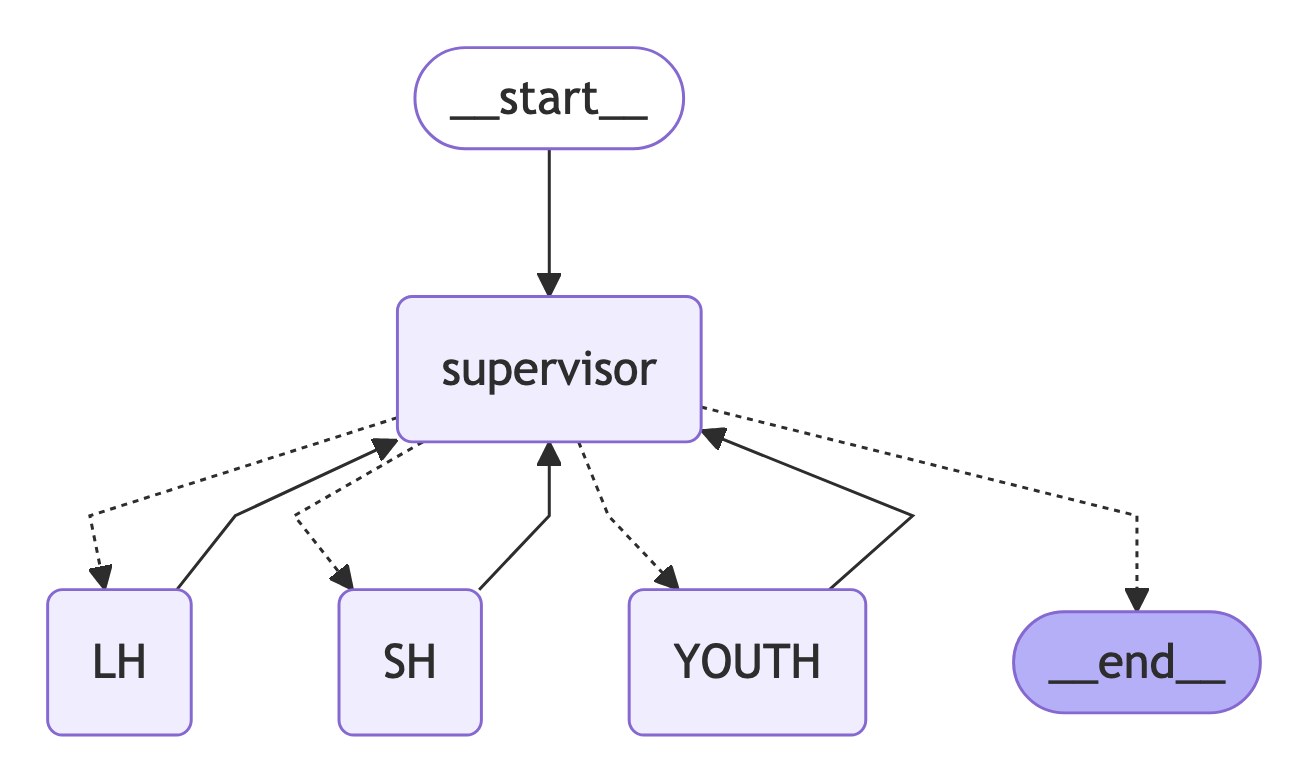

In [63]:

builder = StateGraph(NoticeState)

builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
#builder.add_conditional_edges("supervisor", "YOUTH")
for agent_name, node in [("LH", LH_node), ("SH", SH_node), ("YOUTH", YOUTH_node)]:
    builder.add_node(agent_name, node)
    builder.add_edge(agent_name, "supervisor")
     
builder.add_conditional_edges("supervisor", lambda NoticeState: NoticeState.next)     

builder.set_entry_point("supervisor")

memory = MemorySaver()
#graph = builder.compile(checkpointer=memory, interrupt_before=['human'])
graph = builder.compile(checkpointer=memory)
from IPython.display import display, Image
import nest_asyncio
nest_asyncio.apply()
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.PYPPETEER,
        )
    )
)

In [ ]:
import json
from dataclasses import asdict
from typing import Literal, TypedDict
from langchain_core.messages import ToolMessage  # 또는 Command import 위치에 맞게 조정
from langgraph.types import Command

@dataclass
class GraphState:
    task: str
    notice_url : Optional[str] = None
    notice_info : Optional[NoticeInfo] = None
    notice_abstract : Optional[str] = None
    notice_content :Optional[str] = None
    
main_options = ["subgraph1", "subgraph2", "chat_node"]
# 1) Supervisor 가 반환해야 할 구조 정의
class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*main_options]
# 3) Supervisor Node
def main_supervisor_node(state: GraphState):
    # GraphState를 JSON 형태로 직렬화
    task = state.task
    state_json = json.dumps(asdict(state), ensure_ascii=False, indent=2)
    print(task)
    print(state_json)
    messages = [
        {"role": "system", "content": MAIN_SUPERVISOR_SYSTEM_PROMPT},
        {"role": "user", "content": f"요청한 task : {task} \n 현재 GraphState:\n{state_json}\n 위 상태를 보고 호출할 노드를 결정하세요."}
    ]
    # LLM에게 구조화된 출력으로 호출
    response = llm.with_structured_output(Router).invoke(messages)
    next_node = response["next"]

    return next_node
task = "2024-12-01부터 현재까지 청년안심주택, SH 모집공고를 찾아줘"
sample_url = 'https://www.i-sh.co.kr/main/lay2/program/S1T294C295/www/brd/m_241/view.do?seq=287466'
sample_info = {
    '청약유형': '행복주택', 
    '공고명': '2025년 1차 행복주택 입주자 모집공고 (2025. 4. 25. 공고)', 
    '공고게시일': '2025-04-25', 
    '공고상태': '접수중',
    '공고URL': 'https://www.i-sh.co.kr/main/lay2/program/S1T294C295/www/brd/m_241/view.do?seq=287466', 
    '공고지역': '서울특별시', 
    '공고유형': '임대주택'
    }
task = "공고 기본 정보 정리해줘"
gs = GraphState(task=task, notice_url=sample_url, notice_info = sample_info)
res = main_supervisor_node(state=gs)
print(res)

공고 기본 정보 정리해줘
{
  "task": "공고 기본 정보 정리해줘",
  "notice_url": "https://www.i-sh.co.kr/main/lay2/program/S1T294C295/www/brd/m_241/view.do?seq=287466",
  "notice_info": {
    "청약유형": "행복주택",
    "공고명": "2025년 1차 행복주택 입주자 모집공고 (2025. 4. 25. 공고)",
    "공고게시일": "2025-04-25",
    "공고상태": "접수중",
    "공고URL": "https://www.i-sh.co.kr/main/lay2/program/S1T294C295/www/brd/m_241/view.do?seq=287466",
    "공고지역": "서울특별시",
    "공고유형": "임대주택"
  },
  "notice_abstract": null,
  "notice_content": null
}
chat_node


In [15]:
task = "현재 공고중인 청년안심주택 모집공고와 SH 모집공고를 찾아줘"
config1 = {"configurable": {"thread_id": "user_1"}}
# for s in graph.stream(
#     {"task" : task}, subgraphs=True, config=config1
# ):
#     print(s)
#     print("----")
answer = graph.invoke({"task" : task}, config=config1)
print(answer)

{'agents': ['YOUTH', 'SH']}


╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 청년안심주택 모집 공고를 youth_notice_scraper을 찾고 조건(지역, 기간)에 맞는 게시글들을 찾아서 결과를 정리해.   │
│                                                                                                                 │
│     Tip 1: max_pages 수는 조건 기간 4개월에 페이지 5개를 고려해서 tool 호출.                                    │
│     Tip 2: 최종 결과는 tool Observation을 수정없이 JSON 형태로 출력.                                            │
│                                                                                                                 │
│     Only output should be in JSON format that starts with [{ and ends in }]. Do not output ```json ``` in the   │
│ result.                                                                                                         │
│                                                                                                                 │
│ You have been provided with these additional arguments, that you can access using the keys as variables in your │
│ python code:                                                                                                    │
│ {'조건': {'지역': '서울', '기간': '2025.05.14 ~ 2025.06.14', '청약유형': '청년안심주택', '공고상태': '접수중',  │
│ 'keyword': ''}}.                                                                                                │
│                                                                                                                 │
╰─ OpenAIServerModel - gpt-4.1-mini ──────────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling tool: 'youth_notice_scraper' with arguments: {'max_pages': 5}                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Observations: |{'공고명': '|민간임대] 왕십리역 라봄성동 최초모집공고', '공고게시일': '2025-06-12', '모집마감일': 
'2025-06-23', '청약유형': '민간임대 청년안심주택', '공고상태': '접수중', '공고URL': 
'https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6246&menuNo=400008', '공고지역': '서울특별시', 
'공고유형': '임대주택'}, {'공고명': '|민간임대] 장한평역 장안동 하트리움 추가모집공고', '공고게시일': '2025-06-11',
'모집마감일': '2025-06-12', '청약유형': '민간임대 청년안심주택', '공고상태': '접수마감', '공고URL': 
'https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6244&menuNo=400008', '공고지역': '서울특별시', 
'공고유형': '임대주택'}, {'공고명': '|민간임대] 신림역 최강타워 추가모집공고', '공고게시일': '2025-06-11', 
'모집마감일': '2025-06-14', '청약유형': '민간임대 청년안심주택', '공고상태': '접수마감', '공고URL': 
'https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6243&menuNo=400008', '공고지역': '서울특별시', 
'공고유형': '임대주택'}, {'공고명': '|민간임대] 천호역 효성해링턴타워 추가모집공고', '공고게시일': '2025-06-11', 
'모집마감일': '2025-06-12', '청약유형': '민간임대 청년안심주택', '공고상태': '접수마감', '공고URL': 
'https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6245&menuNo=400008', '공고지역': '서울특별시', 
'공고유형': '임대주택'}, {'공고명': '|민간임대] 서초역 서초꽃마을 주얼리 추가모집공고', '공고게시일': '2025-06-11',
'모집마감일': '2025-06-12', '청약유형': '민간임대 청년안심주택', '공고상태': '접수마감', '공고URL': 
'https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6242&menuNo=400008', '공고지역': '서울특별시', 
'공고유형': '임대주택'}, {'공고명': '|민간임대] 양재역 도곡 더써밋타워 추가모집공고', '공고게시일': '2025-05-27', 
'모집마감일': '2025-05-29', '청약유형': '민간임대 청년안심주택', '공고상태': '접수마감', '공고URL': 
'https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6240&menuNo=400008', '공고지역': '서울특별시', 
'공고유형': '임대주택'}, {'공고명': '|민간임대] 서초역 서초꽃마을 주얼리 추가모집공고', '공고게시일': '2025-05-22',
'모집마감일': '2025-05-22', '청약유형': '민간임대 청년안심주택', '공고상태': '접수마감', '공고URL': 
'https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6237&menuNo=400008', '공고지역': '서울특별시', 
'공고유형': '임대주택'}, {'공고명': '|민간임대] 장한평역 힐데스하임 추가모집공고', '공고게시일': '2025-05-22', 
'모집마감일': '2025-05-22', '청약유형': '민간임대 청년안심주택', '공고상태': '접수마감', '공고URL': 
'https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6238&menuNo=400008', '공고지역': '서울특별시', 
'공고유형': '임대주택'}, {'공고명': '|민간임대] 상봉역 제이스타상봉 추가모집공고', '공고게시일': '2025-05-21', 
'모집마감일': '2025-05-26', '청약유형': '민간임대 청년안심주택', '공고상태': '접수마감', '공고URL': 
'https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6234&menuNo=400008', '공고지역': '서울특별시', 
'공고유형': '임대주택'}, {'공고명': '|민간임대] 신풍역 비스타동원 추가모집공고', '공고게시일': '2025-05-21', 
'모집마감일': '2025-05-23', '청약유형': '민간임대 청년안심주택', '공고상태': '접수마감', '공고URL': 
'https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6236&menuNo=400008', '공고지역': '서울특별시', 
'공고유형': '임대주택'}, {'공고명': '|민간임대] 신대방삼거리역 골든노블레스 추가모집공고', '공고게시일': 
'2025-05-21', '모집마감일': '2025-05-26', '청약유형': '민간임대 청년안심주택', '공고상태': '접수마감', '공고URL': 
'https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6235&menuNo=400008', '공고지역': '서울특별시', 
'공고유형': '임대주택'}, {'공고명': '|민간임대] 노량진역 더써밋타워 추가모집공고', '공고게시일': '2025-05-19', 
'모집마감일': '2025-05-22', '청약유형': '민간임대 청년안심주택', '공고상태': '접수마감', '공고URL': 
'https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6232&menuNo=400008', '공고지역': '서울특별시', 
'공고유형': '임대주택'}, {'공고명': '|민간임대] 노량진역 더클래식 동작 추가모집공고', '공고게시일': '2025-05-19', 
'모집마감일': '2025-05-22', '청약유형': '민간임대 청년안심주택', '공고상태': '접수마감', '공고URL': 
'https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6233&menuNo=400008', '공고지역': '서울특별시', 
'공고유형': '임대주택'}, {'공고명': '|민간임대] 장한평역 장안동 하트리움 추가모집공고', '공고게시일': '2025-05-09',
'모집마감일': '2025-05-10', '청약유형': '민간임대 청년안심주택', '공고상태': '접수마감', '공고URL': 
'https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6229&menuNo=400008', '공고지역': '서울특별시', 
'공고유형': '임대주택'}, {'공고명': '|민간임대] 서울대입구역 BX201 추가모집공고', '공고게시일': '2025-05-09', 
'모집마감일': '2025-05-14', '청약유형': '민간임대 청년안심주택', '공고상태': '접수마감', '공고URL': 
'https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6228&menuNo=400008', '공고지역': '서울특별시', 
'공고유형': '임대주택'}, {'공고명': '|민간임대] 태릉입구역 와이엔타워 예비자 추가모집공고', '공고게시일': 
'2025-05-07', '모집마감일': '2025-05-12', '청약유형': '민간임대 청년안심주택', '공고상태': '접수마감', '공고URL': 
'https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6227&menuNo=400008', '

[Step 0: Duration 4.05 seconds| Input tokens: 1,269 | Output tokens: 18]

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ <STEP 1>: sh_notice_parser를 호출하기위해 max_pages(int) 조건기간을 고려하여 3개월당 1페이지로 값을 설정.       │
│     keyword로 요청이 없을 경우, tool 호출 결과에서 '공고명'에 '발표', '합격자', '경쟁률', '결과'가 포함된       │
│ 항목을 제외. STEP 1 코드를 한 번에 작성. </STEP 1>                                                              │
│     <STEP 2>: !important 조건(기간, 청약유형, 공고상태)들을 고려해서 결과를 다시 필터링. '공고게시일'이         │
│ 기간안에 반드시 포함되어야 함. 필터링 코드는 리스트 컴프리헨션을 사용하고 STEP 2 코드 한번에 작성.</STEP 2>     │
│                                                                                                                 │
│ You have been provided with these additional arguments, that you can access using the keys as variables in your │
│ python code:                                                                                                    │
│ {'조건': {'지역': '서울', '기간': '2025.05.14 ~ 2025.06.14', '청약유형': '', '공고상태': '접수중', 'keyword':   │
│ '', 'sh_url': 'https://housing.seoul.go.kr/site/main/sh/publicLease/list?sc=titl&startDate=&endDate=&sv='}}.    │
│                                                                                                                 │
╰─ OpenAIServerModel - gpt-4.1-mini ──────────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  from datetime import datetime                                                                                    
                                                                                                                   
  # Extract input conditions                                                                                       
  url = 조건['sh_url']                                                                                             
  keyword = 조건['keyword']                                                                                        
  period_str = 조건['기간']                                                                                        
                                                                                                                   
  # Calculate max_pages (3 months per 1 page)                                                                      
  # 기간 format: 'YYYY.MM.DD ~ YYYY.MM.DD'                                                                         
  start_date_str, end_date_str = [s.strip() for s in period_str.split('~')]                                        
  start_date = datetime.strptime(start_date_str, "%Y.%m.%d")                                                       
  end_date = datetime.strptime(end_date_str, "%Y.%m.%d")                                                           
  days_diff = (end_date - start_date).days                                                                         
                                                                                                                   
  # Calculate max_pages: 3 months is roughly 90 days ~ 1 page; so max_pages = ceil(days_diff / 90)                 
  import math                                                                                                      
  max_pages = max(1, math.ceil(days_diff / 90))                                                                    
                                                                                                                   
  # Call the scraper tool                                                                                          
  scraper_result = sh_notice_scraper(url=url, keyword=keyword, max_pages=max_pages)                                
                                                                                                                   
  # If keyword is empty, exclude entries where '공고명' contains specific words                                    
  exclude_words = ['발표', '합격자', '경쟁률', '결과']                                                             
                                                                                                                   
  if keyword == '':                                                                                                
      filtered_result = [entry for entry in scraper_result if not any(word in entry['공고명'] for word in          
  exclude_words)]                                                                                                  
  else:                                                                                                            
      filtered_result = scraper_result                                                                             
                                                                                                                   
  print(filtered_result)                                                                                           
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
[{'청약유형': '수요자맞춤형', '공고명': '[수요자맞춤형 매입임대주택] 성동구 마장행복마을 추가 입주자 모집 공고', 
'공고게시일': '2025-06-13', '공고상태': '접수중', '공고URL': 
'https://www.i-sh.co.kr/main/lay2/program/S1T294C295/www/brd/m_241/view.do?seq=289529', '공고지역': '서울특별시', 
'공고유형': '임대주택'}, {'청약유형': '전세임대', '공고명': '2025년 신혼·신생아(Ⅰ유형) 전세임대 입주자 모집 
공고(2025.6.11.)', '공고게시일': '2025-06-11', '공고상태': '접수중', '공고URL': 
'https://www.i-sh.co.kr/main/lay2/program/S1T294C295/www/brd/m_241/view.do?seq=289479', '공고지역': '서울특별시', 
'공고유형': '임대주택'}, {'청약유형': '도시형생활주택', '공고명': '자립준비청년 2025년 상반기 청년 매입임대주택 
우선공급 입주자모집 공고(2025. 5. 29.)', '공고게시일': '2025-05-29', '공고상태': '접수마감', '공고URL': 
'https://www.i-sh.co.kr/main/lay2/program/S1T294C295/www/brd/m_241/view.do?seq=289048', '공고지역': '서울특별시', 
'공고유형': '임대주택'}, {'청약유형': '장기전세주택', '공고명': '제47차 장기전세주택 입주자 모집공고 (2025.4.30. 
공고)', '공고게시일': '2025-04-30', '공고상태': '접수마감', '공고URL': 
'https://www.i-sh.co.kr/main/lay2/program/S1T294C295/www/brd/m_241/view.do?seq=287727', '공고지역': '서울특별시', 
'공고유형': '임대주택'}, {'청약유형': '매입임대주택', '공고명': '홍은동 청년협동조합[이웃기웃] 잔여세대 입주자 
모집공고(2025.04.30.)', '공고게시일': '2025-04-30', '공고상태': '접수마감', '공고URL': 
'https://www.i-sh.co.kr/main/lay2/program/S1T294C295/www/brd/m_241/view.do?seq=287518', '공고지역': '서울특별시', 
'공고유형': '임대주택'}, {'청약유형': '장기안심주택', '공고명': '2025년 제1차 보증금지원형 장기안심주택 신규 입주자
모집공고', '공고게시일': '2025-04-28', '공고상태': '접수마감', '공고URL': 
'https://www.i-sh.co.kr/main/lay2/program/S1T294C295/www/brd/m_241/view.do?seq=287311', '공고지역': '서울특별시', 
'공고유형': '임대주택'}, {'청약유형': '행복주택', '공고명': '[정정] 2025년 1차 행복주택 입주자 모집공고 (2025. 4. 
25. 공고)', '공고게시일': '2025-04-25', '공고상태': '접수마감', '공고URL': 
'https://www.i-sh.co.kr/main/lay2/program/S1T294C295/www/brd/m_241/view.do?seq=287466', '공고지역': '서울특별시', 
'공고유형': '임대주택'}, {'청약유형': '도시형생활주택', '공고명': '2025-1차 희망하우징(공공기숙사) 입주자 
모집공고(2025.4.11.)', '공고게시일': '2025-04-11', '공고상태': '접수마감', '공고URL': 
'https://www.i-sh.co.kr/main/lay2/program/S1T294C295/www/brd/m_241/view.do?seq=286887', '공고지역': '서울특별시', 
'공고유형': '임대주택'}]

Out: None

[Step 0: Duration 9.59 seconds| Input tokens: 2,541 | Output tokens: 475]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  # Additional filtering conditions                                                                                
  condition_type = 조건['청약유형']                                                                                
  condition_status = 조건['공고상태']                                                                              
                                                                                                                   
  # Function to check if date is within period                                                                     
  def is_within_period(date_str, start, end):                                                                      
      try:                                                                                                         
          date = datetime.strptime(date_str, "%Y-%m-%d")                                                           
          return start <= date <= end                                                                              
      except Exception:                                                                                            
          return False                                                                                             
                                                                                                                   
  final_filtered_result = [                                                                                        
      entry for entry in filtered_result                                                                           
      if is_within_period(entry['공고게시일'], start_date, end_date)                                               
      and (condition_type == '' or entry['청약유형'] == condition_type)                                            
      and entry['공고상태'] == condition_status                                                                    
  ]                                                                                                                
                                                                                                                   
  print(final_filtered_result)                                                                                     
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
[]

Out: None

[Step 1: Duration 4.51 seconds| Input tokens: 7,048 | Output tokens: 754]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer([])                                                                                                 
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: []

[Step 2: Duration 1.41 seconds| Input tokens: 12,072 | Output tokens: 830]

{'task': '현재 공고중인 청년안심주택 모집공고와 SH 모집공고를 찾아줘', 'next': 'human', 'search_params': NoticeSearchOption(지역='서울', 기간='2025.05.14 ~ 2025.06.14', 청약유형='', 공고상태='접수중', keyword='', sh_url='https://housing.seoul.go.kr/site/main/sh/publicLease/list?sc=titl&startDate=&endDate=&sv='), 'YOUTH_notice': [{'공고명': '[민간임대] 왕십리역 라봄성동 최초모집공고', '공고게시일': '2025-06-12', '모집마감일': '2025-06-23', '청약유형': '민간임대 청년안심주택', '공고상태': '접수중', '공고URL': 'https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6246&menuNo=400008', '공고지역': '서울특별시', '공고유형': '임대주택'}, {'공고명': '[민간임대] 장한평역 장안동 하트리움 추가모집공고', '공고게시일': '2025-06-11', '모집마감일': '2025-06-12', '청약유형': '민간임대 청년안심주택', '공고상태': '접수마감', '공고URL': 'https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6244&menuNo=400008', '공고지역': '서울특별시', '공고유형': '임대주택'}, {'공고명': '[민간임대] 신림역 최강타워 추가모집공고', '공고게시일': '2025-06-11', '모집마감일': '2025-06-14', '청약유형': '민간임대 청년안심주택', '공고상태': '접수마감', '공고URL': 'https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6243&menuNo=400008', '공고지역

In [16]:
import json

# answer를 json 형태로 이쁘게 출력하기 위해 NoticeSearchOption을 직렬화 가능하도록 변환
def serialize_notice_search_option(obj):
    if isinstance(obj, NoticeSearchOption):
        return obj.__dict__
    raise TypeError(f"Type {type(obj)} not serializable")

pretty_answer = json.dumps(answer, ensure_ascii=False, indent=4, default=serialize_notice_search_option)
print(pretty_answer)


{
    "task": "현재 공고중인 청년안심주택 모집공고와 SH 모집공고를 찾아줘",
    "next": "human",
    "search_params": {
        "지역": "서울",
        "기간": "2025.05.14 ~ 2025.06.14",
        "청약유형": "",
        "공고상태": "접수중",
        "keyword": "",
        "sh_url": "https://housing.seoul.go.kr/site/main/sh/publicLease/list?sc=titl&startDate=&endDate=&sv="
    },
    "YOUTH_notice": [
        {
            "공고명": "[민간임대] 왕십리역 라봄성동 최초모집공고",
            "공고게시일": "2025-06-12",
            "모집마감일": "2025-06-23",
            "청약유형": "민간임대 청년안심주택",
            "공고상태": "접수중",
            "공고URL": "https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6246&menuNo=400008",
            "공고지역": "서울특별시",
            "공고유형": "임대주택"
        },
        {
            "공고명": "[민간임대] 장한평역 장안동 하트리움 추가모집공고",
            "공고게시일": "2025-06-11",
            "모집마감일": "2025-06-12",
            "청약유형": "민간임대 청년안심주택",
            "공고상태": "접수마감",
            "공고URL": "https://soco.seoul.go.kr/youth/bbs/BMSR00015/view.do?boardId=6244

In [17]:
import pandas as pd
def convert_notices_to_df(state: NoticeState):
    """공고문 정보들을 DataFrame으로 변환합니다."""
    all_notices = []
    
    # _notice로 끝나는 속성들 찾기
    notice_agency = [attr for attr in state.keys() if attr.endswith('_notice')]
    print(notice_agency)
    # 각 공고 리스트에 대해 처리
    for agency in notice_agency:
        agency_name = agency.split('_')[0]  # 'LH_notice' -> 'LH'
        agency_name = "청년안심주택" if agency_name == "YOUTH" else agency_name
        print(agency, agency_name)
        notices = state[agency]
        
        for notice in notices:
            all_notices.append({
                "공고명": notice.get('공고명', ""),
                "공고게시일": notice.get('공고게시일', ""),
                "모집마감일": notice.get('모집마감일', ""),
                "공고상태": notice.get('공고상태', ""),
                "청약유형": notice.get('청약유형', ""),
                "공고URL": notice.get('공고URL', ""),
                "공고지역": notice.get('공고지역', ""),
                "기관유형": agency_name,
                "공고유형": notice.get('공고유형', "")
            })
    
    # DataFrame 생성
    df = pd.DataFrame(all_notices)
    return df
# 공고문 필터링을 위한 ReAct 에이전트 설정
def df_filter(df):
    """공고문 필터링을 위한 ReAct 에이전트를 설정합니다."""
    
    # 필터링 함수 정의
    def filter_notices(df: pd.DataFrame, search_params: Dict[str, Any]) -> pd.DataFrame:
        """검색 조건에 맞게 공고문을 필터링합니다."""
        filtered_df = df.copy()
        
        # 공고상태 필터링
        if search_params.get('공고상태') == '공고중':
            # '공고중'은 '접수중'과 동일하게 취급
            filtered_df = filtered_df[filtered_df['공고상태'] == '접수중']
        elif search_params.get('공고상태'):
            filtered_df = filtered_df[filtered_df['공고상태'] == search_params['공고상태']]
        
        # 지역 필터링
        if search_params.get('지역'):
            filtered_df = filtered_df[filtered_df['공고지역'].str.contains(search_params['지역'], na=False)]
        
        # 청약유형 필터링
        if search_params.get('청약유형'):
            filtered_df = filtered_df[filtered_df['청약유형'].str.contains(search_params['청약유형'], na=False)]
        
        # 키워드 필터링
        if search_params.get('keyword'):
            filtered_df = filtered_df[filtered_df['공고명'].str.contains(search_params['keyword'], na=False)]
            
        return filtered_df.reset_index(drop=True)
    
    # 도구 정의
    tools = [
        {
            "name": "filter_notices",
            "description": "검색 조건에 맞게 공고문을 필터링합니다.",
            "function": filter_notices
        }
    ]
    
    # ReAct 에이전트 생성
    react_agent = create_react_agent(
        llm=llm,
        tools=tools,
        system_prompt="""
        당신은 임대주택 청약 공고문을 필터링하는 전문가입니다.
        사용자가 지정한 검색 파라미터에 따라 공고문을 필터링해야 합니다.
        
        특히 중요한 조건:
        1. 검색 파라미터의 '공고상태'가 '공고중'인 경우에는 '접수중' 상태의 공고문만 반환해야 합니다.
        2. 다른 파라미터(지역, 청약유형, 키워드 등)도 함께 적용해야 합니다.
        
        결과는 DataFrame 형태로 반환해주세요.
        """
    )
    
    return react_agent

df = convert_notices_to_df(answer)
df

['YOUTH_notice', 'SH_notice']
YOUTH_notice 청년안심주택
SH_notice SH


,공고명,공고게시일,모집마감일,공고상태,청약유형,공고URL,공고지역,기관유형,공고유형
0,[민간임대] 왕십리역 라봄성동 최초모집공고,2025-06-12,2025-06-23,접수중,민간임대 청년안심주택,https://soco.seoul.go.kr/youth/bbs/BMSR00015/v...,서울특별시,청년안심주택,임대주택
1,[민간임대] 장한평역 장안동 하트리움 추가모집공고,2025-06-11,2025-06-12,접수마감,민간임대 청년안심주택,https://soco.seoul.go.kr/youth/bbs/BMSR00015/v...,서울특별시,청년안심주택,임대주택
2,[민간임대] 신림역 최강타워 추가모집공고,2025-06-11,2025-06-14,접수마감,민간임대 청년안심주택,https://soco.seoul.go.kr/youth/bbs/BMSR00015/v...,서울특별시,청년안심주택,임대주택
3,[민간임대] 천호역 효성해링턴타워 추가모집공고,2025-06-11,2025-06-12,접수마감,민간임대 청년안심주택,https://soco.seoul.go.kr/youth/bbs/BMSR00015/v...,서울특별시,청년안심주택,임대주택
4,[민간임대] 서초역 서초꽃마을 주얼리 추가모집공고,2025-06-11,2025-06-12,접수마감,민간임대 청년안심주택,https://soco.seoul.go.kr/youth/bbs/BMSR00015/v...,서울특별시,청년안심주택,임대주택
5,[민간임대] 양재역 도곡 더써밋타워 추가모집공고,2025-05-27,2025-05-29,접수마감,민간임대 청년안심주택,https://soco.seoul.go.kr/youth/bbs/BMSR00015/v...,서울특별시,청년안심주택,임대주택
6,[민간임대] 서초역 서초꽃마을 주얼리 추가모집공고,2025-05-22,2025-05-22,접수마감,민간임대 청년안심주택,https://soco.seoul.go.kr/youth/bbs/BMSR00015/v...,서울특별시,청년안심주택,임대주택
7,[민간임대] 장한평역 힐데스하임 추가모집공고,2025-05-22,2025-05-22,접수마감,민간임대 청년안심주택,https://soco.seoul.go.kr/youth/bbs/BMSR00015/v...,서울특별시,청년안심주택,임대주택
8,[민간임대] 상봉역 제이스타상봉 추가모집공고,2025-05-21,2025-05-26,접수마감,민간임대 청년안심주택,https://soco.seoul.go.kr/youth/bbs/BMSR00015/v...,서울특별시,청년안심주택,임대주택
9,[민간임대] 신풍역 비스타동원 추가모집공고,2025-05-21,2025-05-23,접수마감,민간임대 청년안심주택,https://soco.seoul.go.kr/youth/bbs/BMSR00015/v...,서울특별시,청년안심주택,임대주택


: 

In [205]:
df.to_csv('tesd_df.csv', index=False)

In [ ]:
import pandas as pd

# 딕셔너리에서 source 라벨을 붙이고 하나의 리스트로 합치기
all_notices = []
for source, entries in notice.items():
    for entry in entries:
        entry["source"] = source
        all_notices.append(entry)

# DataFrame 생성
df = pd.DataFrame(all_notices)
df

In [49]:
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from langchain.agents.agent_types import AgentType

agent = create_pandas_dataframe_agent(
    llm,
    df,
    verbose=False,
    agent_type=AgentType.OPENAI_FUNCTIONS,
    allow_dangerous_code=True,
)
response = agent.stream("source 열이 SH인 것만 출력해봐")